In [1]:
import os
import re
import opensmile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from opensmile import FeatureSet, FeatureLevel
from contextlib import redirect_stdout

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
path = 'output/'
output_folder = os.listdir(path)
use_deprecated = False

In [3]:
dict_df_featuresets = {}
pattern = r'(Deprecated)'

for file in output_folder:
    csv_path = path+'/'+file
    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.drop(axis=1, columns = ['file', 'start', 'end'])
    if use_deprecated:    
        dict_df_featuresets[file[:-4]] = temp_df
    else:
        if re.findall(pattern, csv_path):
            pass
        else:
            dict_df_featuresets[file[:-4]] = temp_df

In [4]:
for featuresets in dict_df_featuresets:
    print(featuresets)
    
history_collection = {}

ComParE_2016
eGeMAPSv01a
eGeMAPSv02
emobase
GeMAPSv01a
GeMAPSv01b


In [5]:
def sm_model(num_of_features):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=8, strides = 1, activation='relu', input_shape=(num_of_features,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [6]:
features_df = (dict_df_featuresets['emobase'])
print(features_df.shape)

(1975, 989)


In [7]:
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [8]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/emobase-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv, checkpoint]

number_of_features = features_df.shape[1] - 1
model_emobase = sm_model(number_of_features)
history_emobase = model_emobase.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_emobase.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['emobase'] = history_emobase

Epoch 1/100


W1114 15:29:54.269640  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x00000284491FA550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 15:30:07.858342  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002844733BB80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_acc improved from -inf to 0.19036, saving model to saved_models_featuresetTest\emobase-01-0.19.hdf5
87/87 - 14s - loss: 2.2707 - acc: 0.2033 - val_loss: 3.1857 - val_acc: 0.1904 - 14s/epoch - 165ms/step
Epoch 2/100

Epoch 00002: val_acc did not improve from 0.19036
87/87 - 13s - loss: 1.8101 - acc: 0.3307 - val_loss: 3.7895 - val_acc: 0.1590 - 13s/epoch - 155ms/step
Epoch 3/100

Epoch 00003: val_acc did not improve from 0.19036
87/87 - 14s - loss: 1.5890 - acc: 0.4139 - val_loss: 3.3577 - val_acc: 0.1880 - 14s/epoch - 164ms/step
Epoch 4/100

Epoch 00004: val_acc improved from 0.19036 to 0.27229, saving model to saved_models_featuresetTest\emobase-04-0.27.hdf5
87/87 - 14s

Epoch 43/100

Epoch 00043: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.1183 - acc: 0.9616 - val_loss: 1.6220 - val_acc: 0.6241 - 14s/epoch - 160ms/step
Epoch 44/100

Epoch 00044: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.1133 - acc: 0.9674 - val_loss: 1.6274 - val_acc: 0.6482 - 14s/epoch - 161ms/step
Epoch 45/100

Epoch 00045: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.0938 - acc: 0.9711 - val_loss: 1.5848 - val_acc: 0.6361 - 14s/epoch - 163ms/step
Epoch 46/100

Epoch 00046: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.0883 - acc: 0.9689 - val_loss: 1.6570 - val_acc: 0.6410 - 14s/epoch - 161ms/step
Epoch 47/100

Epoch 00047: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.1029 - acc: 0.9616 - val_loss: 1.5634 - val_acc: 0.6506 - 14s/epoch - 164ms/step
Epoch 48/100

Epoch 00048: val_acc did not improve from 0.66988
87/87 - 14s - loss: 0.0979 - acc: 0.9689 - val_loss: 2.0077 - val_acc: 0.6313 - 14s/epoch - 160ms/ste

Epoch 92/100

Epoch 00092: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0394 - acc: 0.9884 - val_loss: 2.1993 - val_acc: 0.6289 - 14s/epoch - 165ms/step
Epoch 93/100

Epoch 00093: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0656 - acc: 0.9826 - val_loss: 2.1029 - val_acc: 0.6337 - 14s/epoch - 166ms/step
Epoch 94/100

Epoch 00094: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0400 - acc: 0.9841 - val_loss: 2.0030 - val_acc: 0.6651 - 14s/epoch - 166ms/step
Epoch 95/100

Epoch 00095: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0712 - acc: 0.9819 - val_loss: 2.0144 - val_acc: 0.6265 - 14s/epoch - 162ms/step
Epoch 96/100

Epoch 00096: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0768 - acc: 0.9754 - val_loss: 2.0613 - val_acc: 0.6361 - 14s/epoch - 162ms/step
Epoch 97/100

Epoch 00097: val_acc did not improve from 0.68193
87/87 - 14s - loss: 0.0495 - acc: 0.9834 - val_loss: 1.8311 - val_acc: 0.6554 - 14s/epoch - 162ms/ste

In [9]:
features_df = (dict_df_featuresets['ComParE_2016'])
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/compare2016-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv, checkpoint]

number_of_features = features_df.shape[1] - 1
model_ComParE_2016 = sm_model(number_of_features)
history_ComParE_2016 = model_ComParE_2016.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_ComParE_2016.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['ComParE_2016'] = history_ComParE_2016

Epoch 1/100


W1114 15:53:55.611422  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000028447695700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 15:55:31.741569  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002844775AD30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_acc improved from -inf to 0.17831, saving model to saved_models_featuresetTest\compare2016-01-0.18.hdf5
87/87 - 101s - loss: 2.2924 - acc: 0.2482 - val_loss: 8.8022 - val_acc: 0.1783 - 101s/epoch - 1s/step
Epoch 2/100

Epoch 00002: val_acc did not improve from 0.17831
87/87 - 101s - loss: 1.7088 - acc: 0.4059 - val_loss: 5.6255 - val_acc: 0.1590 - 101s/epoch - 1s/step
Epoch 3/100

Epoch 00003: val_acc did not improve from 0.17831
87/87 - 100s - loss: 1.2831 - acc: 0.5347 - val_loss: 3.9348 - val_acc: 0.1614 - 100s/epoch - 1s/step
Epoch 4/100

Epoch 00004: val_acc improved from 0.17831 to 0.27470, saving model to saved_models_featuresetTest\compare2016-04-0.27.hdf5
87/87 

Epoch 00092: val_acc did not improve from 0.64096
87/87 - 103s - loss: 0.0672 - acc: 0.9841 - val_loss: 3.4518 - val_acc: 0.6120 - 103s/epoch - 1s/step
Epoch 93/100

Epoch 00093: val_acc did not improve from 0.64096
87/87 - 104s - loss: 0.0697 - acc: 0.9863 - val_loss: 3.3948 - val_acc: 0.5783 - 104s/epoch - 1s/step
Epoch 94/100

Epoch 00094: val_acc did not improve from 0.64096
87/87 - 101s - loss: 0.0728 - acc: 0.9841 - val_loss: 3.7846 - val_acc: 0.5904 - 101s/epoch - 1s/step
Epoch 95/100

Epoch 00095: val_acc did not improve from 0.64096
87/87 - 102s - loss: 0.0739 - acc: 0.9863 - val_loss: 3.5142 - val_acc: 0.5831 - 102s/epoch - 1s/step
Epoch 96/100

Epoch 00096: val_acc did not improve from 0.64096
87/87 - 110s - loss: 0.0688 - acc: 0.9877 - val_loss: 3.5457 - val_acc: 0.6048 - 110s/epoch - 1s/step
Epoch 97/100

Epoch 00097: val_acc did not improve from 0.64096
87/87 - 111s - loss: 0.0328 - acc: 0.9935 - val_loss: 3.2860 - val_acc: 0.6313 - 111s/epoch - 1s/step
Epoch 98/100

Epoc

In [11]:
history_collection['ComParE_2016'] = history_ComParE_2016

In [12]:
features_df = (dict_df_featuresets['eGeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [13]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/egemapsv01a-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv, checkpoint]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv01a = sm_model(number_of_features)
history_eGeMAPSv01a = model_eGeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['eGeMAPSv01a'] = history_eGeMAPSv01a

Epoch 1/100


W1114 18:42:29.369457  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000028447DAE0D0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 18:42:31.611579  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000028449196EE0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_acc improved from -inf to 0.20241, saving model to saved_models_featuresetTest\egemapsv01a-01-0.20.hdf5
87/87 - 3s - loss: 2.4819 - acc: 0.1643 - val_loss: 2.1373 - val_acc: 0.2024 - 3s/epoch - 29ms/step
Epoch 2/100

Epoch 00002: val_acc did not improve from 0.20241
87/87 - 2s - loss: 2.0870 - acc: 0.2424 - val_loss: 2.1047 - val_acc: 0.1855 - 2s/epoch - 17ms/step
Epoch 3/100

Epoch 00003: val_acc improved from 0.20241 to 0.20964, saving model to saved_models_featuresetTest\egemapsv01a-03-0.21.hdf5
87/87 - 1s - loss: 1.9255 - acc: 0.2721 - val_loss: 2.0634 - val_acc: 0.2096 - 1s/epoch - 14ms/step
Epoch 4/100

Epoch 00004: val_acc improved from 0.20964 to 0.23133, saving 

Epoch 87/100

Epoch 00087: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.7560 - acc: 0.7265 - val_loss: 1.2215 - val_acc: 0.5759 - 1s/epoch - 15ms/step
Epoch 88/100

Epoch 00088: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.7326 - acc: 0.7337 - val_loss: 1.2132 - val_acc: 0.5687 - 1s/epoch - 16ms/step
Epoch 89/100

Epoch 00089: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.7342 - acc: 0.7294 - val_loss: 1.2180 - val_acc: 0.5807 - 1s/epoch - 15ms/step
Epoch 90/100

Epoch 00090: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.6860 - acc: 0.7554 - val_loss: 1.2189 - val_acc: 0.5759 - 1s/epoch - 14ms/step
Epoch 91/100

Epoch 00091: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.7048 - acc: 0.7460 - val_loss: 1.2398 - val_acc: 0.5639 - 1s/epoch - 14ms/step
Epoch 92/100

Epoch 00092: val_acc did not improve from 0.59759
87/87 - 1s - loss: 0.6674 - acc: 0.7504 - val_loss: 1.2231 - val_acc: 0.5880 - 1s/epoch - 14ms/step
Epoch 93/100

Ep

In [14]:
features_df = (dict_df_featuresets['eGeMAPSv02'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [15]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/egemapsv02-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv02 = sm_model(number_of_features)
history_eGeMAPSv02 = model_eGeMAPSv02.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv02.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['eGeMAPSv02'] = history_eGeMAPSv02

Epoch 1/100


W1114 18:44:42.496476  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000028447C82820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 18:44:44.286194  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000028449DF1790> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.4362 - acc: 0.1643 - val_loss: 2.1851 - val_acc: 0.1133 - 2s/epoch - 23ms/step
Epoch 2/100
87/87 - 1s - loss: 2.0712 - acc: 0.2359 - val_loss: 2.1949 - val_acc: 0.1181 - 1s/epoch - 14ms/step
Epoch 3/100
87/87 - 1s - loss: 1.9141 - acc: 0.2822 - val_loss: 2.1920 - val_acc: 0.1663 - 1s/epoch - 15ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8226 - acc: 0.3075 - val_loss: 2.0913 - val_acc: 0.1952 - 1s/epoch - 15ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7158 - acc: 0.3437 - val_loss: 1.8523 - val_acc: 0.2747 - 1s/epoch - 15ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6717 - acc: 0.3531 - val_loss: 1.5952 - val_acc: 0.3663 - 1s/epoch - 14ms/step
Epoch 7/100
87/87 - 1s - loss: 1.5973

Epoch 70/100
87/87 - 1s - loss: 0.7729 - acc: 0.7192 - val_loss: 1.1774 - val_acc: 0.5566 - 1s/epoch - 14ms/step
Epoch 71/100
87/87 - 1s - loss: 0.7477 - acc: 0.7243 - val_loss: 1.1820 - val_acc: 0.5542 - 1s/epoch - 13ms/step
Epoch 72/100
87/87 - 1s - loss: 0.8178 - acc: 0.6946 - val_loss: 1.1757 - val_acc: 0.5687 - 1s/epoch - 14ms/step
Epoch 73/100
87/87 - 1s - loss: 0.8040 - acc: 0.7019 - val_loss: 1.1793 - val_acc: 0.5711 - 1s/epoch - 14ms/step
Epoch 74/100
87/87 - 1s - loss: 0.7788 - acc: 0.7178 - val_loss: 1.2142 - val_acc: 0.5711 - 1s/epoch - 13ms/step
Epoch 75/100
87/87 - 1s - loss: 0.7839 - acc: 0.7142 - val_loss: 1.1861 - val_acc: 0.5687 - 1s/epoch - 13ms/step
Epoch 76/100
87/87 - 1s - loss: 0.7368 - acc: 0.7250 - val_loss: 1.1985 - val_acc: 0.5614 - 1s/epoch - 14ms/step
Epoch 77/100
87/87 - 1s - loss: 0.7495 - acc: 0.7164 - val_loss: 1.2099 - val_acc: 0.5759 - 1s/epoch - 14ms/step
Epoch 78/100
87/87 - 1s - loss: 0.7076 - acc: 0.7315 - val_loss: 1.2269 - val_acc: 0.5566 - 1s/e

In [16]:
features_df = (dict_df_featuresets['GeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [17]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/gemapsv01a-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01a = sm_model(number_of_features)
history_GeMAPSv01a = model_GeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['GeMAPSv01a'] = history_GeMAPSv01a

Epoch 1/100


W1114 18:46:45.193781  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x000002844A2E0820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 18:46:46.584273  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000028449F34EE0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.2099 - acc: 0.1910 - val_loss: 2.1461 - val_acc: 0.1807 - 2s/epoch - 18ms/step
Epoch 2/100
87/87 - 1s - loss: 1.9603 - acc: 0.2677 - val_loss: 2.2285 - val_acc: 0.1831 - 668ms/epoch - 8ms/step
Epoch 3/100
87/87 - 1s - loss: 1.8485 - acc: 0.3017 - val_loss: 2.2068 - val_acc: 0.1904 - 654ms/epoch - 8ms/step
Epoch 4/100
87/87 - 1s - loss: 1.7565 - acc: 0.3386 - val_loss: 2.0409 - val_acc: 0.2410 - 675ms/epoch - 8ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7456 - acc: 0.3329 - val_loss: 1.7874 - val_acc: 0.3133 - 679ms/epoch - 8ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6991 - acc: 0.3452 - val_loss: 1.6298 - val_acc: 0.3614 - 656ms/epoch - 8ms/step
Epoch 7/100
87/87 - 1s - lo

Epoch 69/100
87/87 - 1s - loss: 0.9710 - acc: 0.6483 - val_loss: 1.0940 - val_acc: 0.6048 - 647ms/epoch - 7ms/step
Epoch 70/100
87/87 - 1s - loss: 0.9548 - acc: 0.6556 - val_loss: 1.0733 - val_acc: 0.6000 - 653ms/epoch - 8ms/step
Epoch 71/100
87/87 - 1s - loss: 0.9516 - acc: 0.6592 - val_loss: 1.0800 - val_acc: 0.6072 - 648ms/epoch - 7ms/step
Epoch 72/100
87/87 - 1s - loss: 0.9376 - acc: 0.6491 - val_loss: 1.1291 - val_acc: 0.5807 - 641ms/epoch - 7ms/step
Epoch 73/100
87/87 - 1s - loss: 0.9433 - acc: 0.6664 - val_loss: 1.1365 - val_acc: 0.5783 - 655ms/epoch - 8ms/step
Epoch 74/100
87/87 - 1s - loss: 0.9633 - acc: 0.6418 - val_loss: 1.0751 - val_acc: 0.5976 - 675ms/epoch - 8ms/step
Epoch 75/100
87/87 - 1s - loss: 0.9549 - acc: 0.6454 - val_loss: 1.1335 - val_acc: 0.5831 - 664ms/epoch - 8ms/step
Epoch 76/100
87/87 - 1s - loss: 0.9274 - acc: 0.6621 - val_loss: 1.1008 - val_acc: 0.5880 - 663ms/epoch - 8ms/step
Epoch 77/100
87/87 - 1s - loss: 0.9323 - acc: 0.6454 - val_loss: 1.0981 - val_ac

In [18]:
features_df = (dict_df_featuresets['GeMAPSv01b'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [19]:
epoch = 100
batch_size = 16

filepath = 'saved_models_featuresetTest/gemapsv01b-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01b = sm_model(number_of_features)
history_GeMAPSv01b = model_GeMAPSv01b.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01b.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

history_collection['GeMAPSv01a'] = history_GeMAPSv01b

Epoch 1/100


W1114 18:47:54.156096  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x000002844A316D30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1114 18:47:55.533788  7240 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002844A2E0DC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 2s - loss: 2.2971 - acc: 0.1758 - val_loss: 2.1474 - val_acc: 0.1976 - 2s/epoch - 18ms/step
Epoch 2/100
87/87 - 1s - loss: 2.0420 - acc: 0.2475 - val_loss: 2.1025 - val_acc: 0.2096 - 684ms/epoch - 8ms/step
Epoch 3/100
87/87 - 1s - loss: 1.9294 - acc: 0.2656 - val_loss: 2.0983 - val_acc: 0.2048 - 660ms/epoch - 8ms/step
Epoch 4/100
87/87 - 1s - loss: 1.8479 - acc: 0.2822 - val_loss: 1.9948 - val_acc: 0.2627 - 691ms/epoch - 8ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7849 - acc: 0.3234 - val_loss: 1.7678 - val_acc: 0.3181 - 770ms/epoch - 9ms/step
Epoch 6/100
87/87 - 1s - loss: 1.7440 - acc: 0.3524 - val_loss: 1.6181 - val_acc: 0.4169 - 693ms/epoch - 8ms/step
Epoch 7/100
87/87 - 1s - lo

Epoch 69/100
87/87 - 1s - loss: 0.9522 - acc: 0.6454 - val_loss: 1.1414 - val_acc: 0.5855 - 691ms/epoch - 8ms/step
Epoch 70/100
87/87 - 1s - loss: 0.9560 - acc: 0.6440 - val_loss: 1.1439 - val_acc: 0.5807 - 677ms/epoch - 8ms/step
Epoch 71/100
87/87 - 1s - loss: 0.9614 - acc: 0.6447 - val_loss: 1.1768 - val_acc: 0.5687 - 682ms/epoch - 8ms/step
Epoch 72/100
87/87 - 1s - loss: 0.9509 - acc: 0.6462 - val_loss: 1.1787 - val_acc: 0.5639 - 687ms/epoch - 8ms/step
Epoch 73/100
87/87 - 1s - loss: 0.9355 - acc: 0.6592 - val_loss: 1.1427 - val_acc: 0.5904 - 664ms/epoch - 8ms/step
Epoch 74/100
87/87 - 1s - loss: 0.9412 - acc: 0.6606 - val_loss: 1.1988 - val_acc: 0.5494 - 656ms/epoch - 8ms/step
Epoch 75/100
87/87 - 1s - loss: 0.9168 - acc: 0.6679 - val_loss: 1.1612 - val_acc: 0.5976 - 736ms/epoch - 8ms/step
Epoch 76/100
87/87 - 1s - loss: 0.9398 - acc: 0.6592 - val_loss: 1.1831 - val_acc: 0.5687 - 704ms/epoch - 8ms/step
Epoch 77/100
87/87 - 1s - loss: 0.9300 - acc: 0.6671 - val_loss: 1.1444 - val_ac

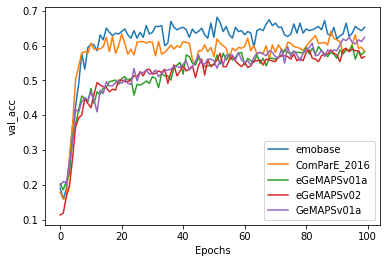

In [20]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_acc']))), history_collection[history].history['val_acc'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.legend()

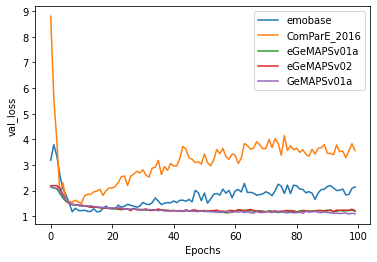

In [21]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_loss']))), history_collection[history].history['val_loss'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend()

In [22]:
print(model_emobase.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 981, 256)          2304      
                                                                 
 batch_normalization (BatchN  (None, 981, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 490, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 490, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 483, 128)          262272    
                                                                 
 batch_normalization_1 (Batc  (None, 483, 128)         5

## Hyperparameter Tuning

In [2]:
def sm_model (hp):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=8, strides = 1, activation='relu', input_shape=(988,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    opt = hp.Choice("opt", values=['adam', 'sgd', 'rmsprop', 'adadelta', 'adamax', 'adagrad'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

    with open('model_summary.txt', 'w') as f:
        with redirect_stdout(f):
            model.summary()

    return model

In [ ]:
# HP tuner search
tuner = RandomSearch(hypermodel = sm_model,
                     objective = "val_acc",
                     max_trials = 6,
                     executions_per_trial = 1,
                     project_name = "Trials")
tuner.search_space_summary()
tuner.search(x_train,
             y_train,
             epochs = 50,
             validation_data =(x_val, y_val),
             verbose = 2
)

tuner.results_summary()